From (https://blog.keras.io/building-autoencoders-in-keras.html) By [Francois Chollet](https://twitter.com/fchollet)
# Autoencoders


![autoencoder](https://www.compthree.com/images/blog/ae/ae.png)

Usually, they are used for extracting latent representations with a lower dimensionality than the input data -> data compression 

## Case: MNIST handwritten digits

### Dataset: 

Train images: 60,000

Test images: 10,000

Image size: 28x28 pixels

![dataset](https://www.researchgate.net/profile/Steven_Young11/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset_W640.jpg)
![image of a digit](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/05/Examples-from-the-MNIST-dataset.png)




In [1]:
# Import MNIST dataset

from keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# labels
y_train

Using TensorFlow backend.


array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [2]:
# show images
import matplotlib.pyplot as plt

def see_images(dataset, n):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(dataset[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

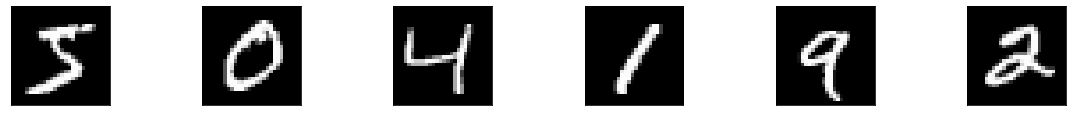

In [3]:
see_images(x_train, 6)

In [4]:
# We need to preprocess our data to use them as input in the network. 
# We normalise the images, each pixel within [0, 1] and format the images into a vector

x_train = x_train.astype('float32') / 255 # 255 max rgb value
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

input_dim = x_train.shape[1]
x_train.shape

(60000, 784)

### Simplest autoencoder
We will use a single fully-connected neural for our encoder and decoder.

Elements:

* Input layer: $y = xI$
* Fully-connected layer: $y = xA^T + b$
* Rectified Linear Unit function: $ReLu(x)=max(0, x)$ (encoder)
* Sigmoid function: $Sigmoid(x) = \sigma(x) = \frac{1}{1+exp(-x)}$ (decoder)

![autoencoder for MNIST](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

In [5]:
from keras.layers import Input, Dense
from keras.models import Model # (template for architecture)

# latent representations dimension
latent_dim = 32
# input layer
input_img = Input(shape=(input_dim, ))

# encoder
encoder = Dense(latent_dim, activation='relu')
encoder_feats = encoder(input_img)

# decoder
decoder = Dense(input_dim, activation='sigmoid')
decoder_out = decoder(encoder_feats)

# model
simple_autoencoder = Model(input_img, decoder_out)

In [6]:
encoder_model = Model(input_img, encoder_feats)
encoded_input = Input(shape=(latent_dim, ))
decoder_model = Model(encoded_input, decoder(encoded_input))

Before training the model, we need to set up the loss function and optimizer.

Loss function per-pixel crossentropy loss

$loss = -[y * log(y' + \epsilon) + (1-y) * log(1-y' + \epsilon)]$


In [7]:
simple_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
# Train model
simple_autoencoder.fit(x_train, x_train,  # the target is the same input data!
                       epochs=50, 
                       batch_size=256, 
                       shuffle=True, 
                       validation_data=(x_test, x_test)) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.3728 - val_loss: 0.2704
Epoch 2/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.2617 - val_loss: 0.2496
Epoch 3/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2400 - val_loss: 0.2283
Epoch 4/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.2211 - val_loss: 0.2116
Epoch 5/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2070 - val_loss: 0.1996
Epoch 6/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.1961 - val_loss: 0.1899
Epoch 7/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.1874 - val_loss: 0.1822
Epoch 8/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.1803 - val_loss: 0.1758
Epoch 9/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.1745 - val_loss: 0.1704
Epoch

'\nsimple_autoencoder.fit(x_train, x_train,\n                epochs=50,\n                batch_size=256,\n                shuffle=True,\n                validation_data=(x_test, x_test))\n'

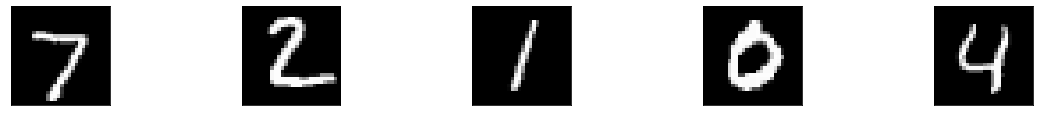

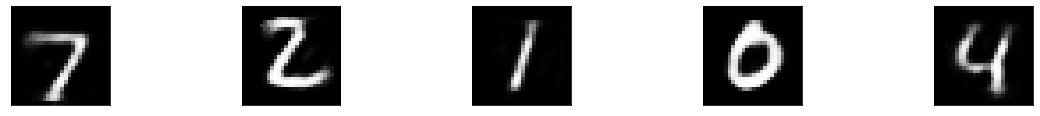

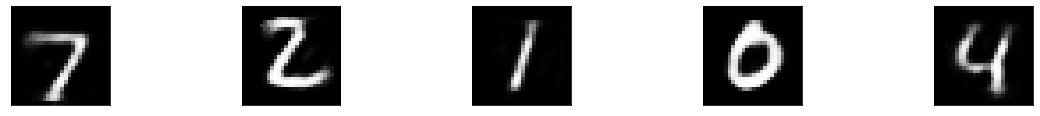

In [10]:
# Predict digits
prediction = simple_autoencoder.predict(x_test)

# Visualisation of predictions
see_images(x_test, 5)
see_images(prediction, 5)

# Using decoder and encoder model
encoded_imgs = encoder_model.predict(x_test)
decoded_imgs = decoder_model.predict(encoded_imgs)

see_images(decoded_imgs, 5)

In [11]:
# latent representations
encoded_imgs[0]

array([ 3.4168975,  9.73697  ,  4.0405474, -0.       ,  2.5260572,
        7.849966 ,  5.9144373,  2.6547973, -0.       ,  4.030358 ,
        7.923523 , 10.401867 , 10.825691 ,  6.086287 ,  5.351529 ,
        7.7557144,  3.1874466,  3.4728453, 12.695125 ,  5.8492384,
        2.665689 , -0.       ,  6.0242333,  3.8416348, 11.725248 ,
        8.529642 ,  8.372928 , 11.944905 , -0.       ,  4.4268446,
        4.178211 ,  7.6326623], dtype=float32)

### Varietional Autoencoder (VAE)

VAE is a generative model that learns the parameters of the probability distribution modelling the input data. 

"A VAE encodes data Y (e.g., a sentence) as hidden random variables Z, based on which the decoder reconstructs Y. Consider a generative model, parameterized by $\theta$, as"

$p_{\theta}(Z,Y) = p_{\theta}(Z)p_{\theta}(Y|Z)$ (Bahuleyan et al., 2018)

**Encoder**: it learns two parameters (`z_mean`, and `z_log_sigma`) in the latent space from the input data, and it randomly samples points from the latent normal distribution (`z = z_mean + exp(0.5 * z_log_sigma) * epsilon`).

**Decoder**: it maps the latent space points to the original input data


**Loss fuctions**: a VAE has two loss functions: the unimodal(reconstruction $l_{re}$) loss as in the simple autoencoder and the KL divergence ($D_{KL}$) between the latent distribution (approximation, learned parameters) and the prior distribution (actual distribution of latent space ?) which works as a regulaser. 

$l_{vae} = l_{re} - D_{KL}$

$l_{vae} = -[y * log(y' + \epsilon) + (1-y) * log(1-y' + \epsilon)] - [0.5 * \frac{1}{n}\sum^{n}{1+z_{sigma} - z_{mean}^2 - e^{z_{sigma}}}]$


In [12]:
# parameters
intermediate_dim = 512 # dimension of points in the latent space
batch_size = 128 
latent_dim = 2 # the two latent parameters z_mean and z_sigma

![architecture sequential VAE](img/VAE_arch.png)
(Kingma and Welling, 2014)

In [17]:
# architecture

inputs = Input(shape=(input_dim, ), name='encoder_input')

# encoder (x -> z_mean & x -> z_log_var)
encoder_1 = Dense(intermediate_dim, activation='relu')
encoder_out_1 = encoder_1(inputs)
z_mean = Dense(latent_dim, name='z_mean')
z_mean_out = z_mean(encoder_out_1)
z_log_sigma = Dense(latent_dim, name='z_log_sigma')
z_log_sigma_out = z_log_sigma(encoder_out_1)



In [28]:
# sampling
from keras import backend as K # operations with tensors

def sampling(params):
    z_mean, z_log_sigma = params
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim)) # mean = 0, std = 1
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon #

# We need to wrap the output of sampling into a layer for connecting it with the decoder. For that we can
# a Lambda layer
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim, ))
z_out = z([z_mean_out, z_log_sigma_out])

In [29]:
# decoder
decoder_1 = Dense(intermediate_dim, activation='relu')
decoder_2 = Dense(input_dim, activation='sigmoid')
decoder_1_out = decoder_1(z_out)
decoder_2_out = decoder_2(decoder_1_out)

In [30]:
# models

# end-to-end autoencoder
vae = Model(inputs, decoder_2_out) 

# from inputs to latent space
encoder_model = Model(inputs, z_mean_out) 

# generator
decoder_input = Input(shape=(latent_dim, ))
_decoder_1_out = decoder_1(decoder_input)
_decoder_2_out = decoder_2(_decoder_1_out)
generator = Model(decoder_input, _decoder_2_out)

In [31]:
# loss
from keras import objectives

def vae_loss(x, x_decoded):
    l_re = objectives.binary_crossentropy(x, x_decoded)
    d_kl = - 0.5 * K.mean(1+z_log_sigma_out - K.square(z_mean_out) - K.exp(z_log_sigma_out), axis=-1)
    return l_re + d_kl

vae.compile(optimizer='rmsprop', loss=vae_loss)

In [32]:
# train 
vae.fit(x_train, x_train,
       shuffle=True,
       epochs=50,
       batch_size=batch_size,
       validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 177us/step - loss: 0.6752 - val_loss: 0.2654
Epoch 2/50
60000/60000 [==============================] - 11s 175us/step - loss: 0.2657 - val_loss: 0.2679
Epoch 3/50
60000/60000 [==============================] - 12s 193us/step - loss: 0.2652 - val_loss: 0.2642
Epoch 4/50
60000/60000 [==============================] - 10s 170us/step - loss: 0.2649 - val_loss: 0.2637
Epoch 5/50
60000/60000 [==============================] - 11s 177us/step - loss: 0.2646 - val_loss: 0.2645
Epoch 6/50
60000/60000 [==============================] - 10s 175us/step - loss: 0.2645 - val_loss: 0.2638
Epoch 7/50
60000/60000 [==============================] - 10s 174us/step - loss: 0.2643 - val_loss: 0.2634
Epoch 8/50
60000/60000 [==============================] - 12s 205us/step - loss: 0.2642 - val_loss: 0.2634
Epoch 9/50
60000/60000 [==============================] - 11s 190us/step - loss: 0.2640 - val_

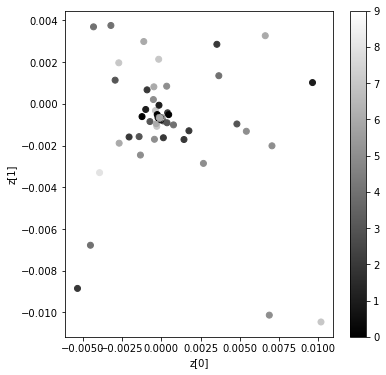

In [36]:
x_test_encoded = encoder_model.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()